# Surface Mass Balance: Time Series 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Using cached feature_engine-1.5.2-py2.py3-none-any.whl (290 kB)
  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\joblib-1.1.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [181]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as pxs
import plotly.graph_objects as go
 
import seaborn as sns

Set WD

In [182]:
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/Thesis/GEUS-Master-Thesis')
os.chdir('E:\GEUS-Master-Thesis')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [183]:
df = pd.read_csv('data/promice/preprocessed/daily/KAN_L.csv')

# Time Series Analysis

##### Pre-processing

In [116]:
# This bit to only focus on the time where we see Ice Ablation
# df = df[df["Ablation"] == True]

In [192]:
df.columns

Index(['Unnamed: 0', 'stid', 'Datetime', 'Air pressure (upper boom)',
       'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Wind from direction (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)',
       'Surface height from combined measurements',
       'Surface height from combined measurements DELTA', 'Albedo',
       'Cloud cover', 'Ablation'],
      dtype='object')

In [184]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre','beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

df.drop(columns=['Melting Season'], inplace=True) 

In [193]:
df = df.drop("Unnamed: 0", axis='columns')


In [91]:
# This bit to include only relevant columns 

#df = df[[column for column in df.columns if column not in exclude_list]]
#df = df.dropna(axis=1,how='all') 
#df = df[df['Surface height from combined measurements'].notna()] #2 missing values in KAN_L 

In [185]:
#See missing values
pd.set_option('display.max_rows', None)
pd.DataFrame(df.isna().sum(), columns = ["Sum of missing values"])

,Sum of missing values
Unnamed: 0,0
stid,0
Datetime,0
Air pressure (upper boom),3
Air temperature (upper boom),3
Relative humidity (upper boom) - corrected,3
Specific humidity (upper boom),3
Wind speed (upper boom),7
Wind from direction (upper boom),7
Downwelling shortwave radiation - corrected,3


In [175]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X= df.loc[:, df.columns != "Surface height from combined measurements"] # All features except y
#X = X.drop("Unnamed: 0", axis='columns')
y=df["Surface height from combined measurements"]

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

### Time series decomposition

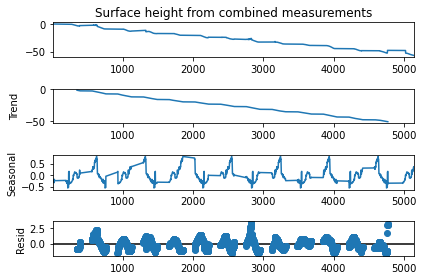

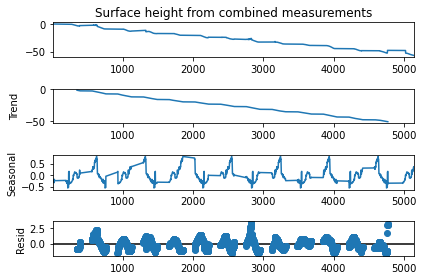

In [201]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
result = seasonal_decompose(df["Surface height from combined measurements"], model="additive", period=365)

# Plot the decomposed components
result.plot()

### Autocorrelation for target variable

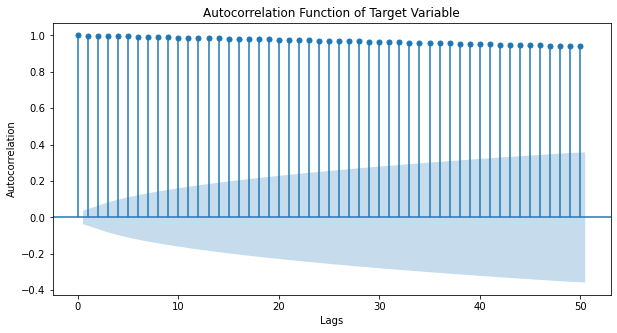

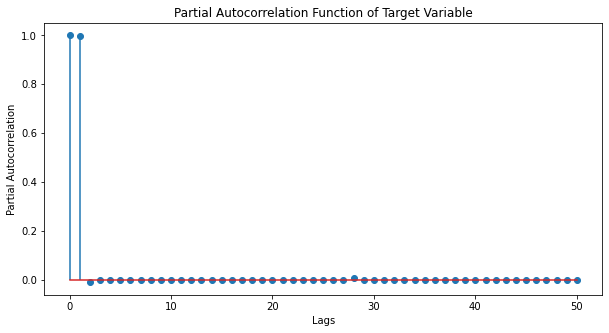

In [189]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf


# Calculate the autocorrelation function of the target variable
lags = 50  # number of lags to include in the analysis
acf_vals = acf(y, nlags=lags, fft=False)

# Plot the autocorrelation function
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(y, lags=lags, ax=ax)
ax.set(title="Autocorrelation Function of Target Variable", xlabel="Lags", ylabel="Autocorrelation")
plt.show()

# Calculate the partial autocorrelation function of the target variable
pacf_vals = pacf(y, nlags=lags)

# Plot the partial autocorrelation function
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(range(lags+1), pacf_vals, use_line_collection=True)
ax.set(title="Partial Autocorrelation Function of Target Variable", xlabel="Lags", ylabel="Partial Autocorrelation")
plt.show()


### Partial Least Squares (PLS)

PLS loadings:
                                                        0         1         2
Specific humidity (upper boom)                   0.519034  0.299081  0.085755
Downwelling longwave radiation                   0.488369  0.302602  0.175448
Upwelling longwave radiation                     0.418147  0.497744  0.133995
Air temperature (upper boom)                     0.413131  0.492997  0.192350
Surface temperature                              0.399007  0.502263  0.140188
Latent heat flux (upper boom)                    0.379307  0.365227  0.123357
Relative humidity (upper boom) - corrected       0.269115  0.452853  0.317475
Cloud cover                                      0.267316  0.108396  0.506313
Albedo                                           0.252651  0.358635  0.231455
Air pressure (upper boom)                        0.200223  0.115829  0.344767
Sensible heat flux (upper boom)                  0.193284  0.186315  0.385652
Upwelling shortwave radiation - corrected        0

C:\Users\asho16ac\AppData\Local\Temp\3/ipykernel_9736/3756220396.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=45, ha='right')


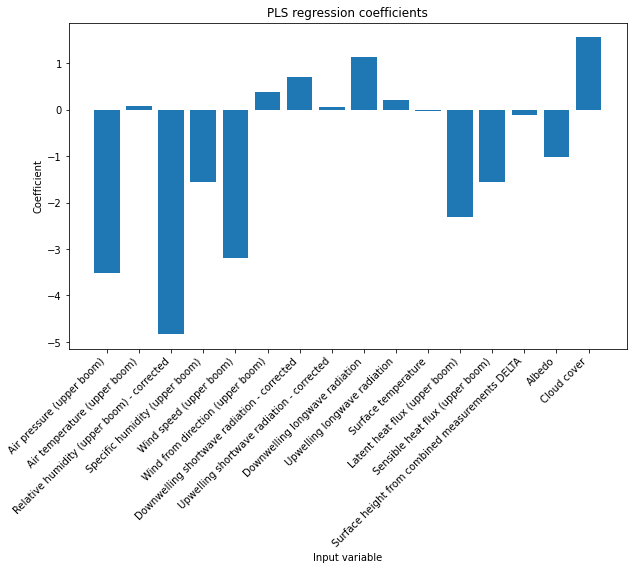

In [188]:
'''
Partial Least Squares (PLS) regression is a method that can identify the variables that have the
strongest relationship with the output variable, while taking into account the correlation between the input variables. 
PLS regression can rank the input variables based on their contribution to the prediction of ice melt.
'''


from sklearn.cross_decomposition import PLSRegression

# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NaN values
df.dropna(inplace=True)


X = df.loc[:, df.columns != "Surface height from combined measurements"].select_dtypes(include=[np.number])  # All features except y
X = X.drop("Unnamed: 0", axis='columns')

y=df["Surface height from combined measurements"]

# Instantiate the PLS regression model
model = PLSRegression(n_components=3)

# Fit the model to the data
model.fit(X, y)

# Get the loadings for each input variable
loadings = pd.DataFrame(model.x_loadings_, index=X.columns)

# Sort the loadings in descending order
loadings = loadings.abs().sort_values(by=0, ascending=False)

# Print the loadings
print('PLS loadings:')
print(loadings)

# Plot the PLS regression coefficients for each input variable
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(X.columns, model.coef_.flatten())
ax.set_xticklabels(X.columns, rotation=45, ha='right')
ax.set_title('PLS regression coefficients')
ax.set_xlabel('Input variable')
ax.set_ylabel('Coefficient')
plt.show()


### Cross-correlation analysis

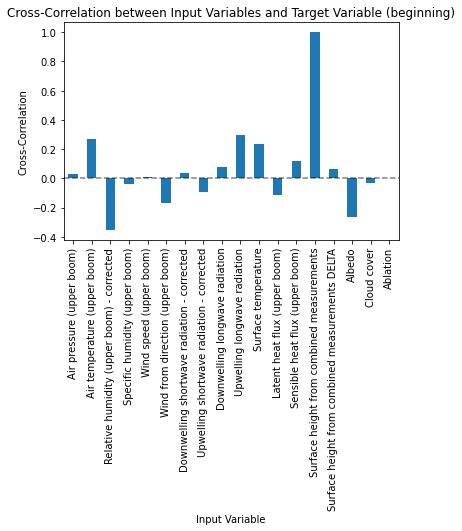

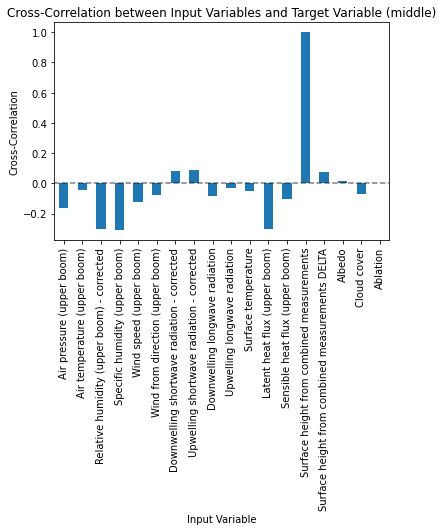

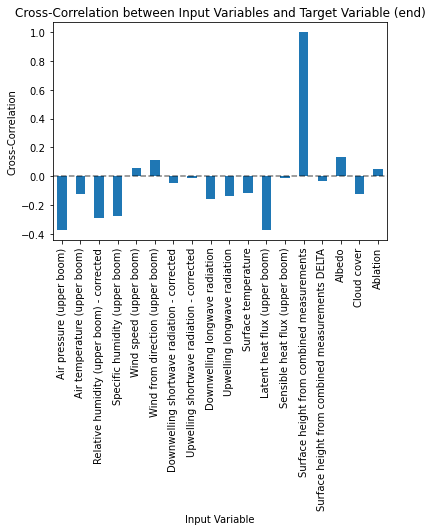

In [195]:
# Explain the results
# The plot shows the cross-correlation values between each input variable and the target variable.
# A positive cross-correlation value indicates a positive relationship between the input variable and the target variable,
# while a negative value indicates a negative relationship. The magnitude of the value indicates the strength of the relationship.
# The plot can be used to identify which input variables have the strongest relationship with the target variable.

# For each period
# Compute the cross-correlation between each input variable and the target variable

for category in ['beginning', 'middle', 'end']:

    indices = eval(f"indices_{category}")  # Get the indices for the current category


    # Find common indexes
    df_indices = indices.intersection(df.index)
    X_indices = indices.intersection(X.index)
    y_indices = indices.intersection(y.index)

    # filter out by indeces
    df_category = df.loc[df_indices]  
    X_category = X.loc[X_indices]  
    y_category = y.loc[y_indices] 
    

    corr = df_category.corrwith(y_category)

    # Plot the cross-correlation values
    fig, ax = plt.subplots()
    corr.plot(kind='bar', ax=ax)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('Input Variable')
    ax.set_ylabel('Cross-Correlation')
    ax.set_title(f'Cross-Correlation between Input Variables and Target Variable ({category})')


In [198]:
X.shape

(2806, 16)

In [199]:
y.shape

(2806,)

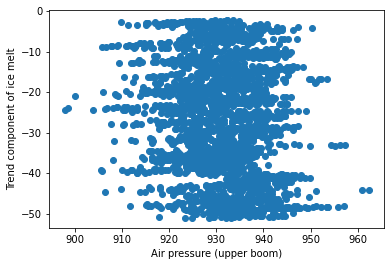

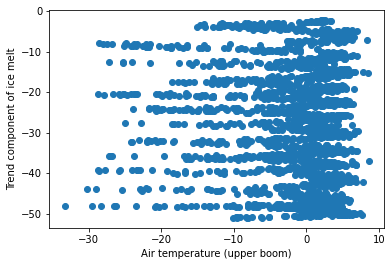

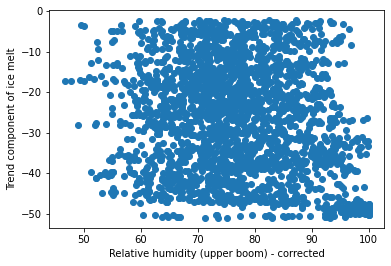

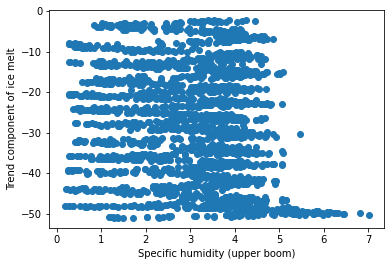

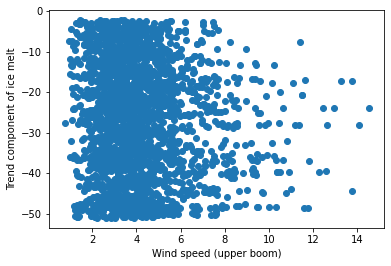

In [202]:
# To visualize the relationship between each input variable and the trend component
# we can create scatter plots with the trend component on the y-axis
# and the input variable on the x-axis. Here is the code to create scatter plots 
# for the top 5 input variables with the highest correlation values:

# Create scatter plots for the top 5 input variables
top_vars = list(corr.keys())[:5]
for var in top_vars:
    plt.scatter(X[var], result.trend)
    plt.xlabel(var)
    plt.ylabel("Trend component of ice melt")
    plt.show()

### Partial correlation analysis

Input variable pairs significantly correlated with the target variable:
Air temperature (upper boom) and Specific humidity (upper boom)
Air temperature (upper boom) and Downwelling longwave radiation
Air temperature (upper boom) and Upwelling longwave radiation
Air temperature (upper boom) and Surface temperature
Air temperature (upper boom) and Albedo
Ablation and Air temperature (upper boom)
Latent heat flux (upper boom) and Relative humidity (upper boom) - corrected
Cloud cover and Relative humidity (upper boom) - corrected
Downwelling shortwave radiation - corrected and Upwelling shortwave radiation - corrected


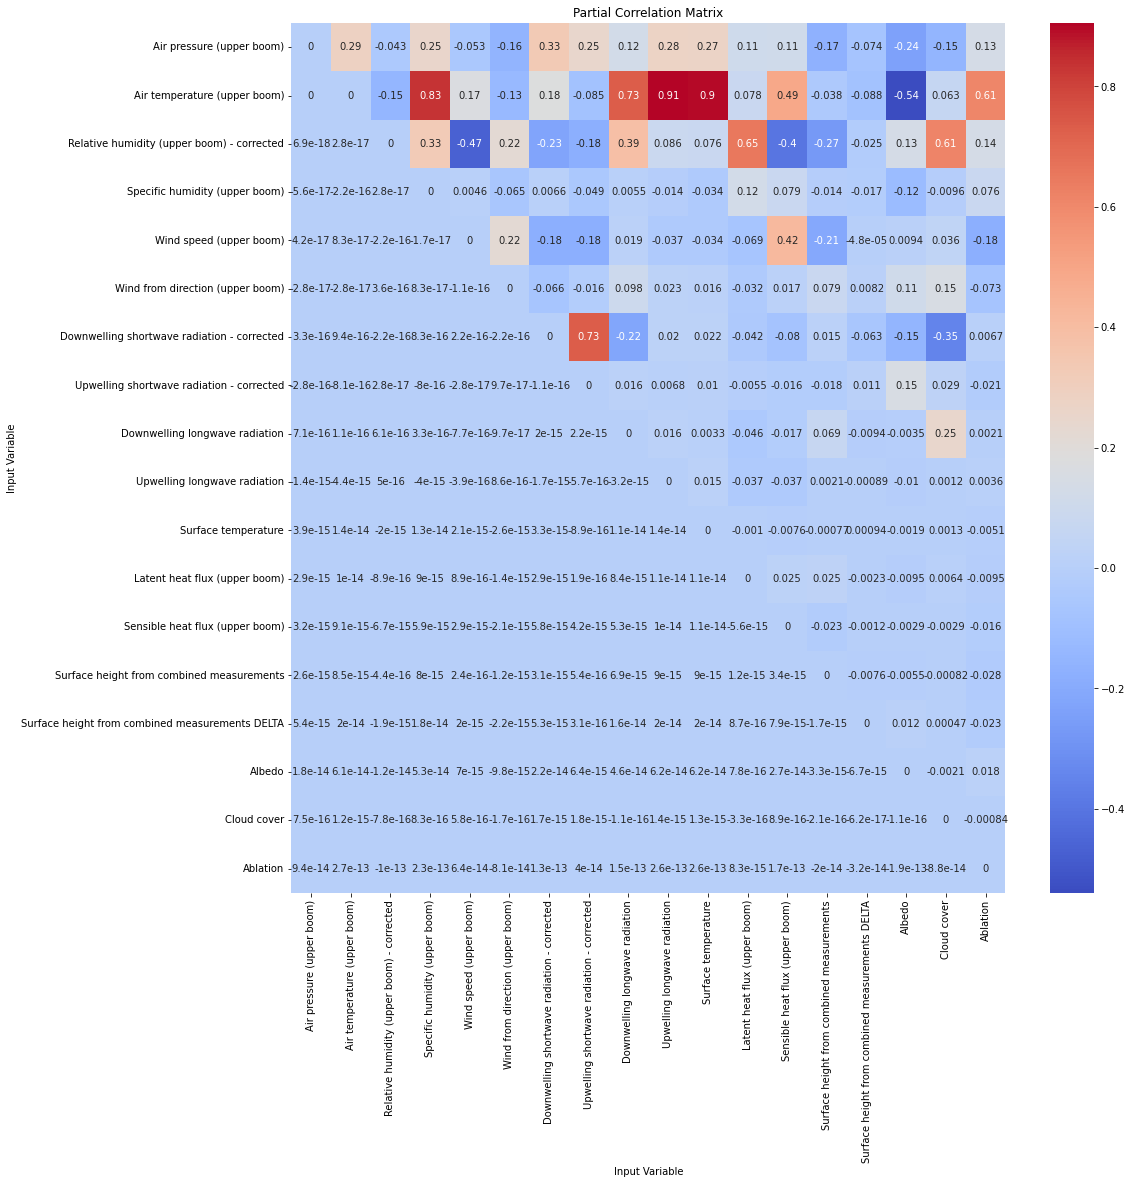

In [203]:
# The heatmap shows the partial correlation values between each input variable and the target variable,
# The partial correlation matrix is computed by subtracting the effects of all other input variables 
# from the correlation values, using the matrix inversion lemma

# Compute the correlation matrix between the input variables
corr_matrix = df.corr()

# Compute the partial correlation matrix between the input variables and the target variable
partial_corr_matrix = pd.DataFrame(np.zeros_like(corr_matrix), index=corr_matrix.index, columns=corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        if i != j:
            partial_corr_matrix.iloc[i, j] = (corr_matrix.iloc[i, j] - 
                                              corr_matrix.iloc[i, :i].dot(np.linalg.inv(corr_matrix.iloc[:i, :i])).dot(corr_matrix.iloc[:i, j]))

# Plot the partial correlation matrix
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(partial_corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_xlabel('Input Variable')
ax.set_ylabel('Input Variable')
ax.set_title('Partial Correlation Matrix')

# Identify the input variables that are significantly correlated with the target variable
significant_vars = list(partial_corr_matrix[(partial_corr_matrix.abs() > 0.5) & (partial_corr_matrix != 1)].stack().index)
significant_vars = [(x, y) if x < y else (y, x) for (x, y) in significant_vars]

# Print the input variable pairs that are significantly correlated with the target variable
if significant_vars:
    print('Input variable pairs significantly correlated with the target variable:')
    for (var1, var2) in significant_vars:
        print(f'{var1} and {var2}')
else:
    print('No input variable pairs significantly correlated with the target variable.')

### Granger causaility


Granger causality results:
Surface height from combined measurements: 0.999999935761207
Upwelling shortwave radiation - corrected: 0.67213942061794
Downwelling shortwave radiation - corrected: 0.6263053883992463
Albedo: 0.36301209416910857
Specific humidity (upper boom): 0.3595456794209602
Air temperature (upper boom): 0.2847132007908451
Upwelling longwave radiation: 0.22831292858201102
Wind speed (upper boom): 0.2127431186550787
Sensible heat flux (upper boom): 0.21175020632763827
Wind from direction (upper boom): 0.1889855672587192
Surface temperature: 0.17927992395450162
Downwelling longwave radiation: 0.14786913569942353
Latent heat flux (upper boom): 0.10186309106172324
Surface height from combined measurements DELTA: 0.08873582404450338
Relative humidity (upper boom) - corrected: 0.007595607975413731
Air pressure (upper boom): 0.0007948712928894738


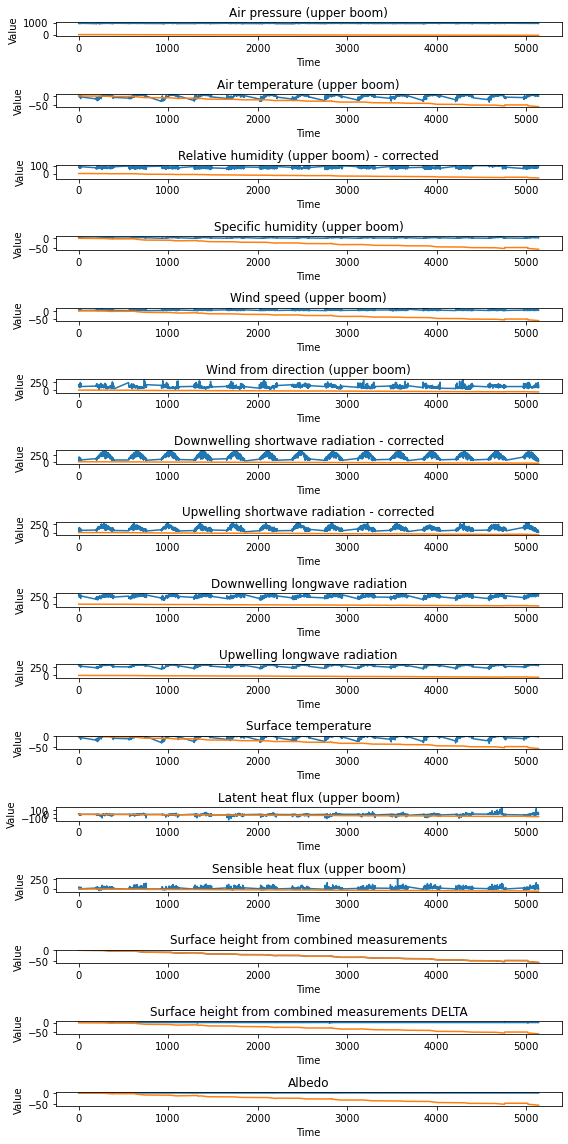

In [204]:
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt


# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NaN values
df.dropna(inplace=True)

# Define the maximum lag to test for Granger causality
# maxlag = 12
maxlag = min(len(df)-1, 12)


# Identify columns with numerical values
num_cols = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]

# Perform the Granger causality test for each input variable
causality = {}
for col in num_cols[:-1]:
    test = grangercausalitytests(df[[col, 'Surface height from combined measurements']], maxlag=maxlag, verbose=False)
    p_values = [test[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
    causality[col] = np.mean(p_values)

# Sort the results in descending order of causality strength
causality = {k: v for k, v in sorted(causality.items(), key=lambda item: item[1], reverse=True)}

# Print the results
print('Granger causality results:')
for col, c in causality.items():
    print(f"{col}: {c}")

# Plot the time series for each input variable and the target variable
fig, axes = plt.subplots(nrows=len(num_cols)-1, ncols=1, figsize=(8, 16))
for i, col in enumerate(num_cols[:-1]):
    axes[i].plot(df[col])
    axes[i].plot(df['Surface height from combined measurements'])
    axes[i].set_title(col)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

